In [2]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from scipy.signal import convolve2d
import cv2

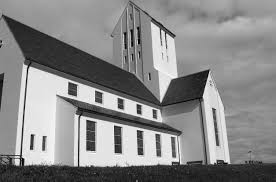

Text(0.5, 1.0, 'Smoothed Image (Sigma=2)')

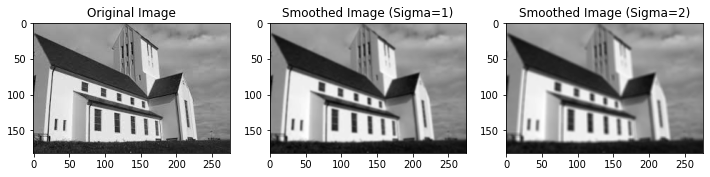

In [3]:
def normal_gaussian_filter(image, gaussian_sigma): #reduce noise by adding a gaussian blur
  sum = 0
  kernel = np.zeros((5,5))
  for y in range(-2, 3):
    for x in range(-2, 3):
      gaussian_value = np.exp((-(y * y + x * x)) / (2 * gaussian_sigma * gaussian_sigma)) / (gaussian_sigma * np.sqrt(2 * np.pi))
      kernel[y + 2][x + 2] = gaussian_value
      sum = sum + gaussian_value
  kernel = np.divide(kernel, sum)

  output = cv2.filter2D(image, -1, kernel)

  return output
im = cv2.imread("image1.png", cv2.IMREAD_GRAYSCALE)
cv2_imshow(im)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
norm_1=normal_gaussian_filter(im,1)
norm_2=normal_gaussian_filter(im,2)
axs[0].imshow(im, cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(norm_1, cmap='gray')
axs[1].set_title('Smoothed Image (Sigma=1)')

axs[2].imshow(norm_2, cmap='gray')
axs[2].set_title('Smoothed Image (Sigma=2)')


Text(0.5, 1.0, 'Smoothed Image (Sigma=2)')

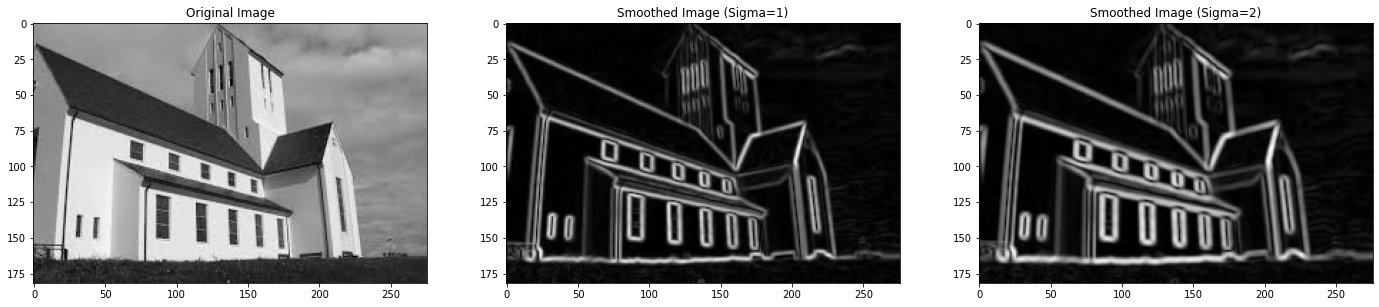

In [4]:
def sobel_operator(image): #finding edges of images based on sobel kernels
  x_kernel = np.matrix([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  y_kernel = np.matrix([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
  
  x_gradient = cv2.filter2D(np.copy(image), cv2.CV_64F, x_kernel)
  y_gradient = cv2.filter2D(np.copy(image), cv2.CV_64F, y_kernel)

  gradient = np.sqrt(np.add(np.square(x_gradient), np.square(y_gradient)))
  gradient = gradient / gradient.max() * 255
  theta = np.arctan2(y_gradient, x_gradient)

  return [x_gradient, y_gradient, gradient, theta]

sobel_1=sobel_operator(norm_1)
sobel_2=sobel_operator(norm_2)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 12))
axs[0].imshow(im, cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(sobel_1[2], cmap='gray')
axs[1].set_title('Smoothed Image (Sigma=1)')

axs[2].imshow(sobel_2[2], cmap='gray')
axs[2].set_title('Smoothed Image (Sigma=2)')

Text(0.5, 1.0, 'Smoothed Image (Sigma=2)')

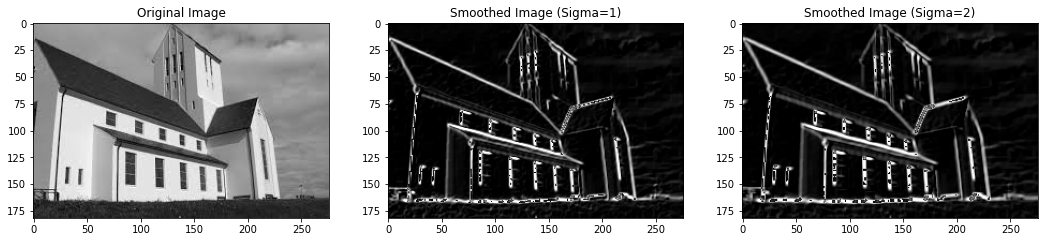

In [5]:
def derivative_gaussian_filter(image, gaussian_sigma):
  x_sum,y_sum = 0,0
  x_kernel,y_kernel = np.zeros((5,5)),np.zeros((5,5))
  for y in range(-2, 3):
    for x in range(-2, 3):
      x_gaussian_value = np.exp((-(y * y + x * x)) / (2 * gaussian_sigma * gaussian_sigma)) / (gaussian_sigma*gaussian_sigma ) * -x
      y_gaussian_value = np.exp((-(y * y + x * x)) / (2 * gaussian_sigma * gaussian_sigma)) / (gaussian_sigma*gaussian_sigma ) * -y
      #print(x_gaussian_value,y_gaussian_value)
      x_kernel[y + 2][x + 2] = x_gaussian_value
      y_kernel[y+2][x+2]=y_gaussian_value
      x_sum = x_sum + x_gaussian_value
      y_sum = y_sum+y_gaussian_value
  output_x = cv2.filter2D(image, -1, x_kernel)
  output_y = cv2.filter2D(image, -1, y_kernel)
  return output_x,output_y

fil_1=derivative_gaussian_filter(np.copy(im),1)
fil_2=derivative_gaussian_filter(np.copy(im),2)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))
axs[0].imshow(im, cmap='gray')
axs[0].set_title('Original Image')


axs[1].imshow(fil_1[1]+fil_1[0], cmap='gray')
axs[1].set_title('Smoothed Image (Sigma=1)')

axs[2].imshow(fil_2[1]+fil_2[0], cmap='gray')
axs[2].set_title('Smoothed Image (Sigma=2)')

Text(0.5, 1.0, 'non-maximum suppression output')

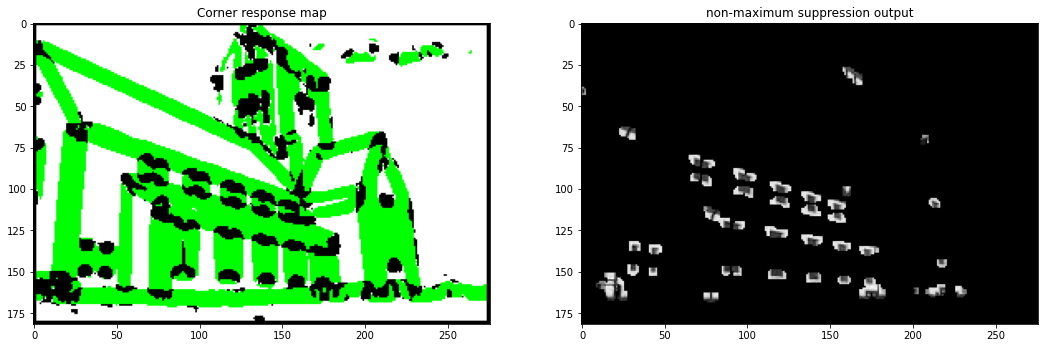

In [64]:

def harris_corner_detection(image, gaussian_sigma, threshold):
  # #Apply Gaussian Filter
  gaussian = normal_gaussian_filter(image, gaussian_sigma)

  #Finding Intensity Gradient of the Image
  sobel = sobel_operator(gaussian)
  Ixx = sobel[0] * sobel[0]
  Ixy = sobel[0] * sobel[1]
  Iyy = sobel[1] * sobel[1]

  output = np.zeros((image.shape[0], image.shape[1], 3))

  for y in range(2, output.shape[0] - 2):
    for x in range(2, output.shape[1] - 2):
      Sxx = np.sum(Ixx[y - 2 : y + 3, x - 2 : x + 3])
      Sxy = np.sum(Ixy[y - 2 : y + 3, x - 2 : x + 3])
      Syy = np.sum(Iyy[y - 2 : y + 3, x - 2 : x + 3])
            
      det = (Sxx * Syy) - (Sxy * Sxy)
      trace = Sxx + Syy
      r = det - 0.05 * trace * trace

      if (r > threshold): #corner
        output[y][x] = [0, 0, 0]
      elif (r < threshold * -1):
        output[y][x] = [0,255 ,0 ]
      else: 
        output[y][x] = [255, 255, 255]
  nms_corners=cv2.cornerMinEigenVal(image,blockSize=5, ksize=3)
  nms_corners = cv2.dilate(nms_corners, None)
  nms_corners[(nms_corners < 0.25*np.max(nms_corners))] = 0
  nms_corners[(nms_corners > 0)] = 255
  nms_corners = nms_corners.astype(np.uint8)
  non_max = cv2.bitwise_and(image, image, mask=nms_corners)
  return output,non_max
results=(harris_corner_detection(im, 5, 30000000))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
axs[0].imshow(results[0], cmap='gray')
axs[0].set_title('Corner response map')


axs[1].imshow(results[1], cmap='gray')
axs[1].set_title('non-maximum suppression output')

